## Training DCGAN on MNIST

### Intro
[DCGAN](https://arxiv.org/abs/1511.06434) is a an architecture for generative adversarial nets based on stacked convolutional layers. In the original paper use it to demonstrate *interpolation between bedrooms* and *face algebra* -- wonderful stuff. 

Here, I'm just going to train a (version of) DCGAN on the standard MNIST dataset and try to take a peek at the guts of the network.

Necessary imports: PyTorch for building and training the model, torchvision for easy access to the dataset.

In [1]:
import torch
import numpy as np
import torchvision

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, Dataset

In [3]:
DATA = "data/"

The torchvision dataset consists of (PIL, label) pairs, where PIL is a digit image (28 x 28), and label the corresponding ground-truth label.

In [4]:
%%capture
mnist_ds= torchvision.datasets.MNIST(DATA, download=True)

Here's an example of some images from the training set:
![train-samples](saved_images/real/real_step_0.png)

In [5]:
import torchvision.transforms as transforms

This collects all image transformations we want to apply before feeding transformations to the machine. Here only a rescaling of the images is applied, to put pixel values in the range [-1, 1] (this matches the generator's tanh() output)

In [6]:
rescale = lambda x: 2 * x -1 

In [7]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
                    rescale
])

A simple dataset for providing image tensors on demand. In fact, it provides labels as well, though I'm not using those.

In [8]:
class MNISTDS(Dataset):
    def __init__(self, mnist_ds, transform):
        super().__init__()
        self.mnist_ds= mnist_ds
        self.transform = transform
    def __len__(self):
        return len(self.mnist_ds)
    def __getitem__(self, i):
        return self.transform(self.mnist_ds[i][0]), self.mnist_ds[i][1]
    

In [9]:
ds = MNISTDS(mnist_ds, transform)

## Building the model

In [10]:
import torch.nn as nn

The DCGAN architecture is a bunch of stacked "transposed convolutions". If you're wondering what a "tranposed" convolution is, as I was when I tried to set this network up, see [here](https://github.com/vdumoulin/conv_arithmetic) for some very helpful visualizations. The punchline is: it's an ordinary convolution, but where the *stride* is used to "inflate" the input image before feeding it to the conv filter, so that the outputs can end up being larger in spatial extent than the inputs.

Here, I'm basically copying the [example pytorch implementation of DCGAN](https://github.com/pytorch/examples/blob/master/dcgan/main.py). Only slight modifications are required to fit the generator and discriminator to MNIST data.

## The Generator
The principle of the generator is to map *noise vectors* to *fake images*, the former being distributed according to some simple (here, standard-normal) prior, by some deterministic operation. For DCGAN, the latter is defined by upsampling with a sequence of transposed convolutions. 

We start with a noise, or "latent" vector of size (100,1,1), and  treat its last two dimensions as spatial. In effect, the latent vector is a 1x1 image, with 100 indepedent noisy channels. 

This is then fed through **four transposed convolutional layers**. They all use the same kernel size (4), and
The first transpose-conv layer uses 64 * 4 filters. As we move up through each subsequent Conv layer in the stack, the number of filters *halves* at each layer, while the linear size of the image *doubles*. The doubling is acheived by setting stride 2 and padding 1 (the definition of 'padding' here is confusing -- see pytorch docs). In between the Conv layers, we use batch normalization, and ReLU for a nonlinearity.

The output is obtained by passing the final conv layer though a tanh filter.

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        """latent_size = size of the latent space"""
        super(Generator, self).__init__()
        
        self.latent_size = latent_size
        
        #kernel size
        self.kernel_size =4
        #(proportional to the) number of generator filters
        self.ngf = 64
        
        #takes a latent vector and outputs MNIST-sized image
        #input: (_, nz, 1, 1) latent vector
        self.upsample = nn.Sequential(
            
                                nn.ConvTranspose2d(self.latent_size, 4 * self.ngf, self.kernel_size,
                                                      stride=1,padding=0,bias=False), 
                                nn.BatchNorm2d( 4 * self.ngf), 
                                nn.ReLU(),
                                #spatial extent here is set by the kernel: (4,4)
                                
                                #by setting stride=2, we effectively double the output size (up to fiddling
                                #with the boundary conditions..)
                                # Weirdly, increasing the 'padding' arg actually decreases the amount of padding 
                                #that's applied to the input. the only reason padding is being used here is to
                                #keep the output shapes at nice multiples of two
                                nn.ConvTranspose2d(4 * self.ngf, 2 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False), 
                                nn.BatchNorm2d( 2 * self.ngf), 
                                nn.ReLU(),
                                
                                #( 8,8)
                                nn.ConvTranspose2d(2 * self.ngf, 1 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False), 
                                nn.BatchNorm2d( 1 * self.ngf), 
                                nn.ReLU(),
                                #(16,16)
                                #here I'm increasing the padding to bring the output size to (28,28)
                                #for MNIST
                                nn.ConvTranspose2d(self.ngf, 1, self.kernel_size,
                                                      stride=2,padding=3, bias=False), 
                                nn.Tanh(),
                                #(32,32)
                                
                                                                                            
                                )
        
    def forward(self, z):
        """Input: (_, latent_size) noise tensor
            Output: (_, 1, 32, 32) generated image tensor"""
        z = z.view(-1, self.latent_size, 1, 1)
        return self.upsample(z)

## The Discriminator 
Roughly speaking, this looks like the generator run in reverse. Four conv layers are applied to input images, with the number of filters *doubling* at each step, and the spatial extent *halving*. This time a LeakyReLU nonlinearity is observed, on the advice of the DCGAN authors.

The output is a single sigmoid neuron, interpreted as the probability of the input coming from the real data distribution.

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #scaling for the number of filters
        self.nf = 64
        # kernel size 
        self.kernel_size = 4
        #input (1,28,28)
        
        #this is more or less the generator stack run in reverse
        # a stride of 2 and padding of 1 causes the spatial extent to halve at each step
        self.main = nn.Sequential(
            nn.Conv2d(1, self.nf, self.kernel_size, stride=2,padding=3, bias=False),
            nn.LeakyReLU(.2),
            nn.Conv2d(self.nf, 2 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(2*self.nf, 4 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(4*self.nf, 1 , self.kernel_size, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        """Input: (_, 1, 28, 28) image
            Output: (_, 1) classification tensor"""
        x = x.view(-1, 1, 28,28)
        return self.main(x).view(-1)

Take a gpu if it's available

In [13]:
devname = "cuda:0" if torch.cuda.is_available() else "cpu"

In [14]:
device = torch.device(devname)

The size of the latent space. I put no thought into this!

In [15]:
latent_size = 100

Initialize the Conv and BatchNorm layers. Apparently these values work well. This initializer is copied directly from the pytorch example mentioned above.

In [16]:
def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)

Build the generator and discriminator, and move them to gpu

In [17]:
G = Generator(latent_size).to(device)
D = Discriminator().to(device)

Initialize the weights

In [18]:
G.apply(weight_init)
D.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [19]:
batch_size = 64

In [20]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [21]:
loss = nn.BCELoss()

Pick a convention for labeling real and fake data. This amounts to a convention for what the discriminator represents. If `real_label=1`, it correponds to `p(real | image)`.

In [22]:
real_label = 1
fake_label = 1- real_label

These hyperparameters are straight from the DCGAN paper.

In [23]:
lr = 2e-4
beta=.5

One optimizer for each network. Makes it easy to update the two different sets of weights in alternating steps.

In [24]:
optimizerD = torch.optim.Adam(D.parameters(), lr=lr,betas=(beta, .999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr,betas=(beta, .999))

How many passes to take over the dataset.

In [25]:
epochs = 10

In [26]:
from torchvision.utils import save_image

For tracking the discriminator and generator loss functions during training.

In [27]:
disc_losses = []
gen_losses = []


In [28]:
savestep=0

### Model training

Each batch update consists of two steps: first, the discriminator tries to maximize the number of real and fake images it correctly classifies (you can think of this as attempting to match the true posterior distribution over 'real' and 'fake' labels, which is why a binary cross-entropy loss is appropriate). Next, the generator tries to maximize the probability of *misclassification* of its own outputs. Note that no real data is used in this step.

Samples from the generator are periodically recorded.

In [29]:
for epoch in range(epochs):
    print("Starting epoch %d..." % epoch)
    for i, (x,y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)

        #size of current batch
        N = x.shape[0]
        ## update the discriminator
        disc_real = D(x)
        real_probs = torch.full((N,), real_label, device=device)
        disc_loss_real = loss(disc_real, real_probs)

        z = torch.randn(N, latent_size,1,1,device=device)
        #detach here, so gradients don't flow to the generator
        fake_outputs = G(z).detach()
        disc_fake = D(fake_outputs)
        fake_probs = torch.full((N,), fake_label, device=device)
        disc_loss_fake = loss(disc_fake, fake_probs)

        D.zero_grad()
        disc_loss = disc_loss_real+ disc_loss_fake
        disc_loss.backward()
        #update disc weights only
        optimizerD.step()

        ## update the generator
        z = torch.randn(N, latent_size, 1, 1, device=device)
        disc_fake = D(G(z))
        fake_labels = torch.full((N,), real_label, device=device)
        gen_loss = loss(disc_fake, fake_labels)

        G.zero_grad()
        gen_loss.backward()
        optimizerG.step()   
    
        if i % 25 ==0:
            disc_losses.append(disc_loss.item())
            gen_losses.append(gen_loss.item())
        
            #save some examples of real and fake images
            save_image((x+1)/2, "saved_images/real_step_%d.png"%savestep)
            save_image((fake_outputs+1)/2, "saved_images/fake_step_%d.png"%savestep)
            savestep += 1

    #save the models every epoch
    torch.save(D.state_dict(), "saved_models/discriminator_epoch%d"%epoch)
    torch.save(G.state_dict(), "saved_models/generator_epoch%d"%epoch)

Starting epoch 0...
Starting epoch 1...
Starting epoch 2...
Starting epoch 3...
Starting epoch 4...
Starting epoch 5...
Starting epoch 6...
Starting epoch 7...
Starting epoch 8...
Starting epoch 9...


In [33]:
import numpy as np
np.save("saved_models/generator_loss", gen_losses)
np.save("saved_models/discriminator_loss", disc_losses)

Look at the generator and discriminator losses during training:

In [34]:
import matplotlib.pyplot as plt

Text(0,0.5,'Gen. loss')

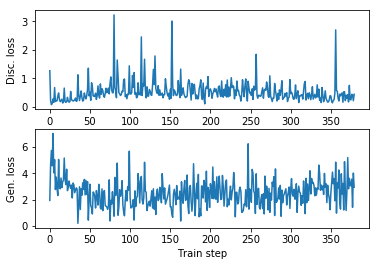

In [36]:
fig, axes = plt.subplots(2,1)

ax = axes[0]
ax.plot(disc_losses)
ax.set_ylabel("Disc. loss")

ax = axes[1]
ax.plot(gen_losses)
ax.set_xlabel("Train step")
ax.set_ylabel("Gen. loss")


![](saved_images/fake_step_299.png)

Here's a sample of the generator outputs at the end of training:

![fake-samples](saved_images/fake_step_378.png)

The samples are crisp and diverse, and I'm impressed by the variation in stroke width. What's cool about the GAN is that, when it makes mistakes, it seems to make human-like mistakes -- writing a *single digit* sloppily, for example, rather than blurring several similar digits together. 

Here's a time lapse of samples from the generator, each frame corresponding to one "savestep". The digits become realistic remarkably quickly -- even a few epochs will produce crisp samples.

![fake-timelapse](saved_images/fake.gif)